# Customer Churn Prediction


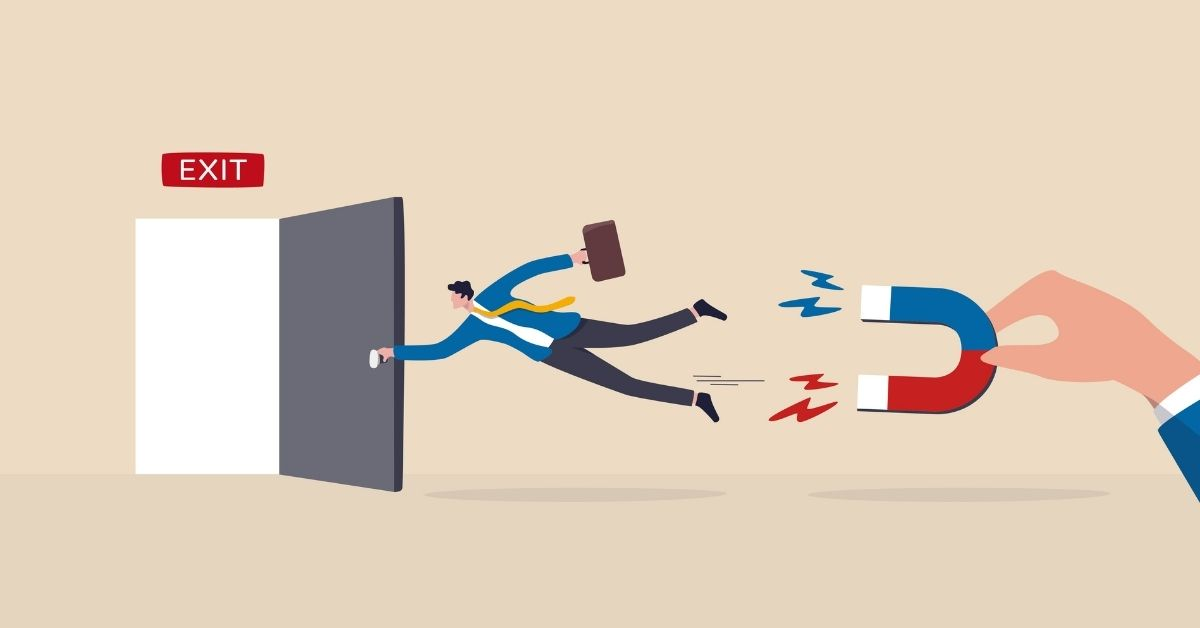

## Introduction


In the competitive landscape of telecommunications, retaining existing customers is as crucial as acquiring new ones. Customer churn, which occurs when subscribers discontinue their service, is a significant challenge and can lead to substantial revenue loss. The objective of this project is to develop a machine learning tool that predicts the likelihood of customers churning. By identifying at-risk customers, the telecom company can proactively engage them with targeted communication and retention strategies, such as special offers and promotions.

## Business Goal

The primary aim is not just to create a highly accurate churn prediction model, but to prioritize the identification of customers who are more likely to churn. The focus is on maximizing the model's recall for churned customers – we prefer to err on the side of flagging a customer as a potential churner rather than missing one. This allows the telecom company to cast a wider net with its retention campaigns, thereby potentially saving more customers from churning.



## Dataset

Loading dataset of Telco Customer churn to DataFrame.

[Dataset can be found here.](https://www.kaggle.com/datasets/blastchar/telco-customer-churn)

> Indented block



In [170]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import drive

drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/WA_Fn-UseC_-Telco-Customer-Churn.csv')

df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Feature engineering

In [171]:
df.rename(columns={'gender':'Gender'
                       ,'Contract':'ContractType'
                       ,'tenure':'Tenure'
                      }
              ,inplace=True)

# Converting binary features to binary

cols = ['Partner', 'Dependents',  'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV','StreamingMovies', 'PaperlessBilling', 'Churn']

for i in cols:
    df[i] = [1 if each == "Yes" else 0 if each == "No" else 0 for each in df[i]]


# Fixing TotalCharges
df.loc[df.TotalCharges ==' ','TotalCharges'] = np.nan

df.TotalCharges = df.TotalCharges.astype('float64')
df.loc[df['TotalCharges'].isna(), 'TotalCharges'] = df['MonthlyCharges'] * df['Tenure']

# Adding HasInternetService
df['HasInternetService'] = df.InternetService.map({'DSL':1,'Fiber optic':1,'No':0})
# Adding Is Contracted
df['HasContract'] = df.ContractType.map({'One year':1,'Two year':1,'Month-to-month':0})
# Putting tenure into bins of 12 months
labels = ["{0} - {1}".format(i, i + 11) for i in range(1, 72, 12)]

df['TenureGroup'] = pd.cut(df.Tenure, range(1, 80, 12), right=False, labels=labels)
df['TenureGroup'].value_counts()
df = df.drop('Tenure', axis=1)
# Drop CustomerID
df = df.drop('customerID', axis=1)

df.head()

,Gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,...,StreamingMovies,ContractType,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,HasInternetService,HasContract,TenureGroup
0,Female,0,1,0,0,0,DSL,0,1,0,...,0,Month-to-month,1,Electronic check,29.85,29.85,0,1,0,1 - 12
1,Male,0,0,0,1,0,DSL,1,0,1,...,0,One year,0,Mailed check,56.95,1889.50,0,1,1,25 - 36
2,Male,0,0,0,1,0,DSL,1,1,0,...,0,Month-to-month,1,Mailed check,53.85,108.15,1,1,0,1 - 12
3,Male,0,0,0,0,0,DSL,1,0,1,...,0,One year,0,Bank transfer (automatic),42.30,1840.75,0,1,1,37 - 48
4,Female,0,0,0,1,0,Fiber optic,0,0,0,...,0,Month-to-month,1,Electronic check,70.70,151.65,1,1,0,1 - 12


In [172]:
categorical_features = ['Gender','InternetService','PaymentMethod','ContractType', 'TenureGroup']
binary_features = ['SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','OnlineSecurity','OnlineBackup'
               ,'DeviceProtection','TechSupport','StreamingTV', 'StreamingMovies','PaperlessBilling','HasInternetService'
               , 'HasContract']
numeric_features = ['MonthlyCharges']
target = 'Churn'

In [173]:
df = pd.get_dummies(df, columns=categorical_features)
df.head()

,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,...,PaymentMethod_Mailed check,ContractType_Month-to-month,ContractType_One year,ContractType_Two year,TenureGroup_1 - 12,TenureGroup_13 - 24,TenureGroup_25 - 36,TenureGroup_37 - 48,TenureGroup_49 - 60,TenureGroup_61 - 72
0,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0
1,0,0,0,1,0,1,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0
2,0,0,0,1,0,1,1,0,0,0,...,1,1,0,0,1,0,0,0,0,0
3,0,0,0,0,0,1,0,1,1,0,...,0,0,1,0,0,0,0,1,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0


## Exploratory data analysis

### Checking if there are any null values

In [174]:
df.isnull().sum()


SeniorCitizen                              0
Partner                                    0
Dependents                                 0
PhoneService                               0
MultipleLines                              0
OnlineSecurity                             0
OnlineBackup                               0
DeviceProtection                           0
TechSupport                                0
StreamingTV                                0
StreamingMovies                            0
PaperlessBilling                           0
MonthlyCharges                             0
TotalCharges                               0
Churn                                      0
HasInternetService                         0
HasContract                                0
Gender_Female                              0
Gender_Male                                0
InternetService_DSL                        0
InternetService_Fiber optic                0
InternetService_No                         0
PaymentMet

### Shape of the data

In [177]:
print("Records, features")
df.shape

Records, features


(7021, 35)

### Check if there are any duplicates

In [176]:
df = df.drop_duplicates()
df.duplicated().sum()

0

## Describe the data

In [178]:
df.describe()

,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,...,PaymentMethod_Mailed check,ContractType_Month-to-month,ContractType_One year,ContractType_Two year,TenureGroup_1 - 12,TenureGroup_13 - 24,TenureGroup_25 - 36,TenureGroup_37 - 48,TenureGroup_49 - 60,TenureGroup_61 - 72
count,7021.000000,7021.000000,7021.000000,7021.000000,7021.000000,7021.000000,7021.000000,7021.000000,7021.000000,7021.000000,...,7021.000000,7021.000000,7021.000000,7021.000000,7021.000000,7021.000000,7021.000000,7021.000000,7021.000000,7021.000000
mean,0.162512,0.484546,0.300527,0.902863,0.423159,0.287566,0.345962,0.344965,0.291127,0.385558,...,0.227318,0.548782,0.209799,0.241419,0.306651,0.145848,0.118502,0.108532,0.118502,0.200399
std,0.368947,0.499797,0.458520,0.296166,0.494095,0.452660,0.475715,0.475391,0.454314,0.486761,...,0.419130,0.497650,0.407194,0.427974,0.461136,0.352979,0.323224,0.311073,0.323224,0.400327
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Churned vs Non-Churned users

0    0.735508
1    0.264492
Name: Churn, dtype: float64

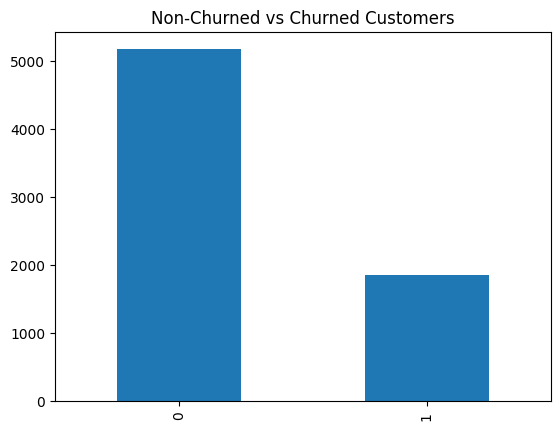

In [183]:
df['Churn'].value_counts()
df['Churn'].value_counts().plot(kind='bar', title='Non-Churned vs Churned Customers')
df.Churn.value_counts(normalize=True)

**Thoughts:** It seems that more users stay with the company. Therefore, we need to consider that the model can be more biased to predict users to be non-churned.

## Feature correlation with churn

<Axes: >

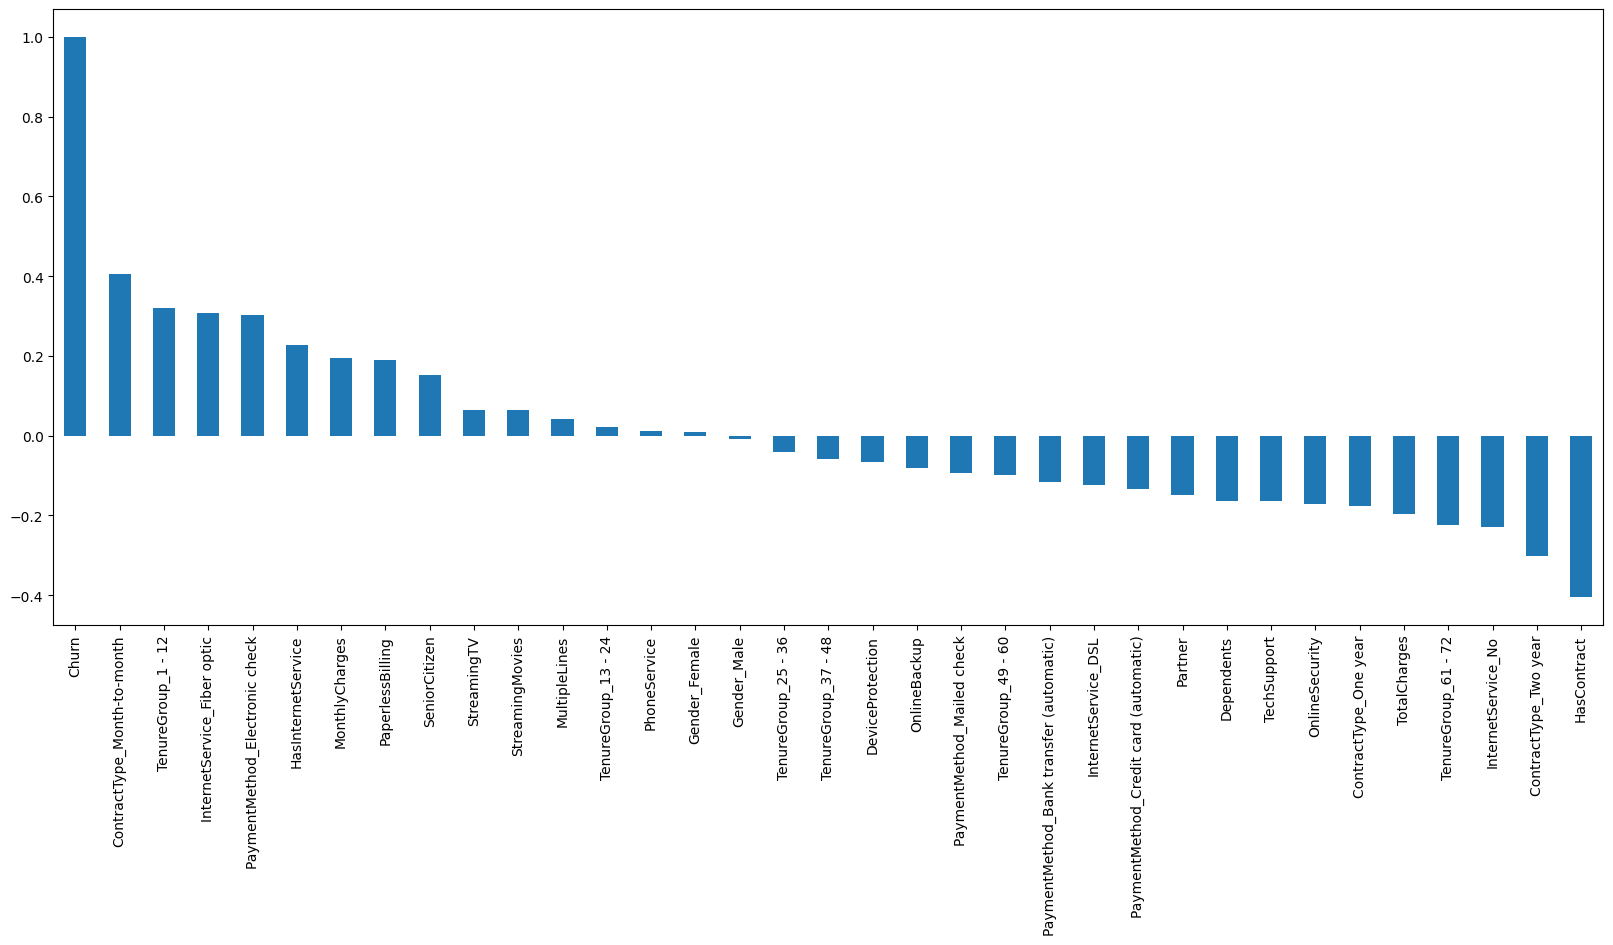

In [184]:
plt.figure(figsize=(20,8))
df.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

The correlation graph presents an insightful overview of how different features within the Telco dataset may influence customer churn. Notably:

**Contract Type:** Customers with month-to-month contracts show a strong positive correlation with churn, suggesting that customers not bound by long-term contracts are more likely to leave the service. Conversely, longer-term contracts (one-year and two-year) are negatively correlated with churn, indicating more stability with these customers.

**Tenure Groups:** There's a notable trend where shorter tenure correlates positively with churn, which aligns with the intuition that new customers are more prone to churn. Longer tenure groups exhibit negative correlations, highlighting the retention of more established customers.

**Payment Methods:** The method of payment also appears to impact churn rates. Automated payments (like bank transfers and credit cards) have a negative correlation with churn, whereas electronic checks are positively correlated, suggesting that customers using electronic checks are more likely to churn.

**Services:** Certain services such as online security, tech support, and device protection are negatively correlated with churn, implying that customers who subscribe to these services are less likely to churn. This could indicate that the perceived value or customer satisfaction with these services contributes to customer retention.

**Demographics:** Gender shows a very low correlation with churn, suggesting that churn behavior does not differ significantly between males and females in this dataset. The 'SeniorCitizen' feature has a positive correlation, indicating that senior citizens are more likely to churn compared to non-senior citizens.

**Billing and Charges:** Interestingly, customers with paperless billing and those with higher monthly charges are more correlated with churn, which might reflect customer sensitivity to price or a preference for traditional billing methods.

## Heat map of feature correlation

<Axes: >

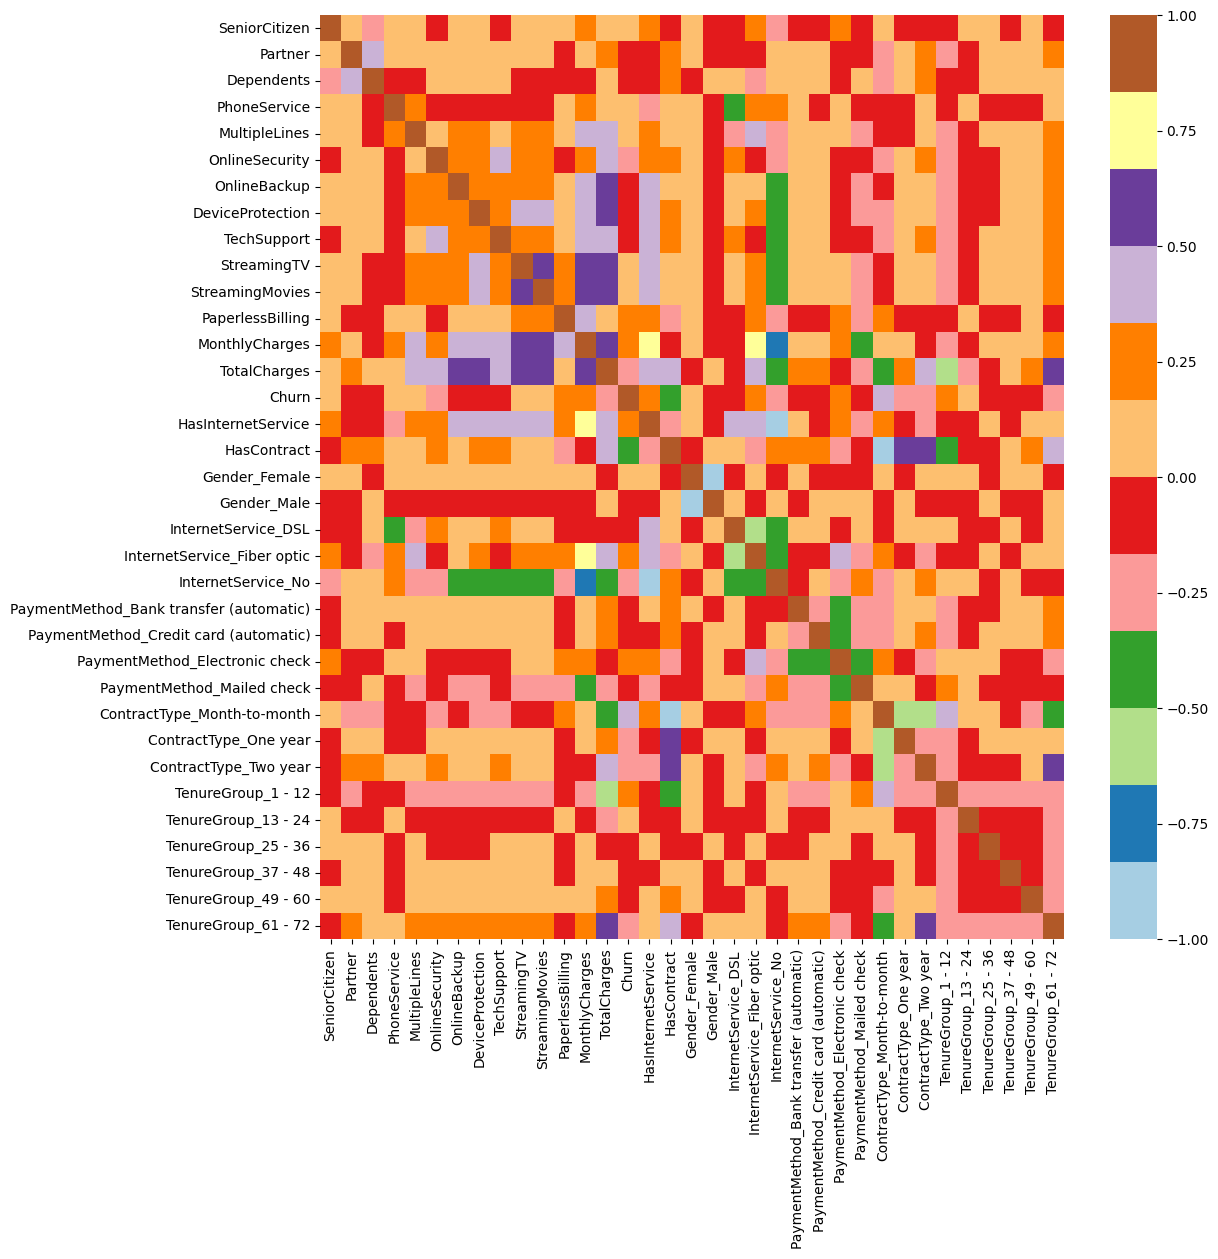

In [185]:
plt.figure(figsize=(12,12))
sns.heatmap(df.corr(), cmap="Paired")

## Choosing a Model


After thorough exploratory data analysis (EDA) on the Telco customer dataset, I believe **logistic regression** could serve as a beneficial model for several reasons:

1. **Relationship Between Features and Target:** The exploratory data analysis (EDA) on the Telco customer dataset indicates that several features have a relationship with the likelihood of churn. This includes tenure, monthly charges, and various services. Unlike linear regression, logistic regression is specifically designed for binary outcomes, such as churn (yes or no). It models the probability of an outcome based on the input variables. This makes it more suitable for a churn prediction model, as it directly predicts the probability of a customer churning.

2. **Interpretability:** Logistic regression maintains a high level of interpretability, similar to linear regression. The coefficients in a logistic regression model represent the change in the log-odds of the dependent variable (churning) for a one unit change in the predictor variable, holding other variables constant. This can provide clear insights into which factors are most likely to influence customer churn.

3. **Speed and Simplicity:** Logistic regression, like linear regression, is relatively simple and computationally efficient. It is well-suited for large datasets and situations where the model needs to be updated frequently with new data. This simplicity also helps in understanding and explaining the model to stakeholders who may not be familiar with more complex machine learning methods.

4. **Foundation for Complex Models:** Logistic regression can serve as an excellent baseline model for churn prediction. It allows you to establish a performance benchmark before moving on to more complex models like random forests or neural networks. If logistic regression provides satisfactory results, it might negate the need for more complex models, which are often harder to interpret and require more computational resources.



## Building a model

Given our primary objective to engage with the maximum number of customers at risk of churn, our focus is on maximizing recall to minimize false negatives. High recall ensures that we correctly identify and reach out to as many potentially churning customers as possible.

To achieve this, we must address the class imbalance inherent in our dataset, as an uneven distribution of churned versus non-churned customers can bias the model towards the majority class. Additionally, we will implement feature scaling to ensure that our model accurately captures the importance of each predictor without being skewed by the range of values.

### Class imbalance

In [186]:
df.Churn.value_counts(normalize=True)

0    0.735508
1    0.264492
Name: Churn, dtype: float64

In [187]:
weight_for_0 = 1 / 0.73463
weight_for_1 = 1 / 0.26537

weight_for_0 = weight_for_0 / min(weight_for_0, weight_for_1)
weight_for_1 = weight_for_1 / min(weight_for_0, weight_for_1)

class_weight = {0: weight_for_0, 1: weight_for_1}

class_weight = compute_class_weight('balanced', classes=[0, 1], y=y)
class_weight_dict = {0: class_weight[0], 1: class_weight[1]}

### Scaling and normalization

In [188]:
df['MonthlyCharges'] = df['MonthlyCharges'] / df['MonthlyCharges'].max()

df['TotalCharges'] = df['TotalCharges'] / df['TotalCharges'].max()

df.head()

,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,...,PaymentMethod_Mailed check,ContractType_Month-to-month,ContractType_One year,ContractType_Two year,TenureGroup_1 - 12,TenureGroup_13 - 24,TenureGroup_25 - 36,TenureGroup_37 - 48,TenureGroup_49 - 60,TenureGroup_61 - 72
0,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0
1,0,0,0,1,0,1,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0
2,0,0,0,1,0,1,1,0,0,0,...,1,1,0,0,1,0,0,0,0,0
3,0,0,0,0,0,1,0,1,1,0,...,0,0,1,0,0,0,0,1,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0


### Training

In [189]:
X = df.drop(target, axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)



In [190]:
model = LogisticRegression(class_weight=class_weight_dict, max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(class_weight={0: 0.6806146115191342, 1: 1.8841626538255751},
                   max_iter=1000)

### Evaluation

In [192]:
print(X_test.columns)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

Index(['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling',
       'MonthlyCharges', 'TotalCharges', 'HasInternetService', 'HasContract',
       'Gender_Female', 'Gender_Male', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'ContractType_Month-to-month', 'ContractType_One year',
       'ContractType_Two year', 'TenureGroup_1 - 12', 'TenureGroup_13 - 24',
       'TenureGroup_25 - 36', 'TenureGroup_37 - 48', 'TenureGroup_49 - 60',
       'TenureGroup_61 - 72'],
      dtype='object')
              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1053
           1       0.48      0.79 

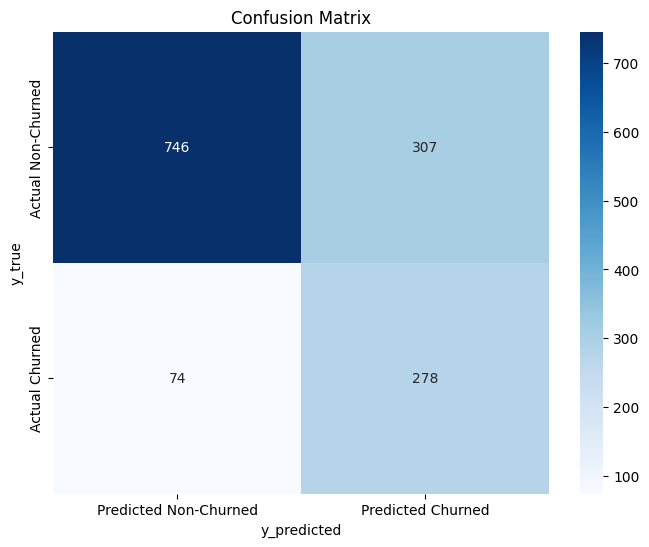

In [193]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Predicted Non-Churned', 'Predicted Churned'], yticklabels=['Actual Non-Churned', 'Actual Churned'])
plt.ylabel('y_true')
plt.xlabel('y_predicted')
plt.title('Confusion Matrix')
plt.show()

In [194]:
tn, fp, fn, tp = cm.ravel()

print(f'True Negatives (TN): {tn}')
print(f'False Positives (FP): {fp}')
print(f'False Negatives (FN): {fn}')
print(f'True Positives (TP): {tp}')

True Negatives (TN): 746
False Positives (FP): 307
False Negatives (FN): 74
True Positives (TP): 278


# Conclusions


The results indicate that the model has a high precision (92%) for predicting the non-churners (class 0), suggesting that when it predicts a customer will not churn, it is very likely to be correct. However, the recall for this class is lower (73%), which means the model misses around 27% of the actual non-churners. For the churners (class 1), the recall is quite high at 82%, indicating the model is effective at identifying customers at risk of churning, which aligns with our goal to target potential churners. Nonetheless, the precision for churners is relatively low (52%), meaning that the model incorrectly labels non-churning customers as churners quite often. This trade-off results in an overall accuracy of 75%, which is acceptable given our emphasis on recall. The weighted average f1-score of 0.76 reflects a balance between precision and recall across the dataset, considering the class imbalance.

# Export

Let's export the model into a file.

In [167]:
from joblib import dump

dump(model, 'churn_model.pkl')

['churn_model.pkl']